1. Deklaracja klasy 'matrix', która obsługuje mnożenie i potęgowanie macierzy

In [65]:
def frange(st, end, tick):
  res = []
  while(st <= end):
    res.append(st)
    st += tick
    st = round(st, 12)
  return res

In [28]:


class matrix:
    def __init__(self, vals = [[1, 0], [0, 1]]):
        self.mac = vals

    def __mul__(self, oth):
        if( len ( self.mac[0] ) != len(oth.mac)):
            raise AttributeError('Width of the first matrix MUST match the height of the second matrix. Sizes are ' + str( len ( self.mac[0] )) + ' ' + str (len(oth.mac)) )
        w = len(self.mac[0]) 
        h = len(self.mac)
        gl = len(self.mac[0])
        new = [[0] * w  for i in range(h)]
        for i in range(h):
            for j in range(w):
                for t in range(gl):
                    new[i][j] += self.mac[i][t] * oth.mac[t][j]
                #print(new[i][j])
        return matrix(new)
    
    #Potęgowanie za pomocą szybkiego potęgowania macierzy

    def __pow__(self, exp):

        res = neutral(len(self.mac))  
        c_base = matrix(self.mac)

        it_bit = 1
        while(it_bit <= exp):
            if(it_bit & exp):
                res *= c_base
            c_base *= c_base
            it_bit <<= 1
        
        return res
        
def neutral(width):
    res = []
    for i in range(width):
        now = []
        for j in range(width):
            now.append ( int(i == j) )
        res.append(now)
    return matrix(res)

#print(neutral(3).mac)
a = matrix([[1, 2], [2, 1]])

print( (a**2).mac )
print( (a**3).mac)




    

[[5, 4], [4, 5]]
[[13, 14], [14, 13]]


2. Test dla prostej funkcji z dx/dt = kx 

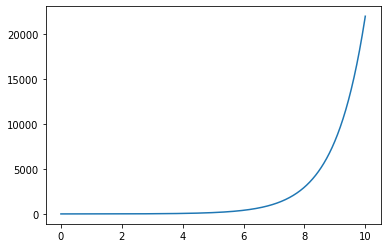

In [78]:
from matplotlib import pyplot as plt
# x(t) = x(t-1) + ( k * x(t-1) ) * dt
def gen_fun1(k, dt):
    return matrix([
        [k*dt, k*dt],
        [1   , 1] ])

x0 = 1

m_dt = 0.000001 # Delta t macierzy
r_dt = 0.01  # Delta t obliczana/wyświetlana
t_max = 10  # Czas symulacji

t = [0]
x = [x0]

x_mac = matrix ( [[x0, x0], [0,0]] )
f1_mac = gen_fun1(1, m_dt)
f1_mac = f1_mac**( int ( r_dt / m_dt ) ) # Każdy 'przeskok' obliczeniowy ma długość (r_dt / m_dt). MUSI BYĆ CAŁKOWITE (inaczej nie miałoby sensu)

while ( t[-1] < t_max):
    t.append ( round ( t[-1] + r_dt, 12 ) )
    x_mac *= f1_mac
    x.append ( x_mac.mac[0][0] )

plt.plot(t, x)
plt.show()

2b. Prównanie side-by-side

Rozmiar tablicy : 101
Rozmiar tablicy : 101
Rozmiar tablicy : 101
Rozmiar tablicy : 101
Rozmiar tablicy : 101


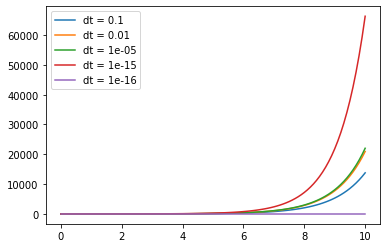

In [30]:

r_dt = 0.1
t_max = 10

legend = []

for m_dt in [0.1, 0.01, 0.00001, 0.000000000000001, 0.0000000000000001]:
    x0 = 1
    
    t = [0]
    x = [x0]

    x_mac = matrix ( [[x0, x0], [0,0]] )
    f1_mac = gen_fun1(1, m_dt)
    f1_mac = f1_mac**( int ( r_dt / m_dt ) ) # 1 przeskok jest 10 razy większy. MUSI BYĆ CAŁKOWITE
    #print(f1_mac.mac)
    while ( t[-1] < t_max):
        t.append ( round ( t[-1] + r_dt, 12 ) )
        x_mac *= f1_mac
        x.append ( x_mac.mac[0][0] )

    plt.plot(t, x)
    print( "Rozmiar tablicy :" , len(x) )
    legend.append( "dt = " + str(m_dt) )

plt.legend(legend)

plt.show()

Obserwacja : dt nie może być mniejsze niż 1e-15, bo inaczej python zaokrągla zmiany do 1

Konkluzja : Nie udało się osiągnąć zamierzanej dokładności, jednak postęp jest spory - wykres z dokładnością 1e-16 iteracyjnie kalkulowałby się 10^10 sekund lub 321 lat (zakładając 10^6 op/sek)

3. Test dla równania logistycznego dx/dt = kx(1 - x/N)

[[1, 1.0000000000000002e-10, 0], [0, 1, 1], [0, -2.0000000000000002e-11, 1]]


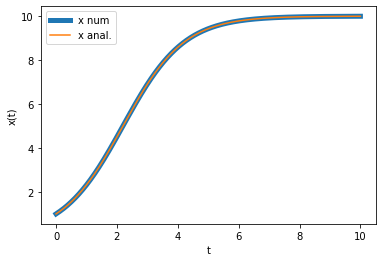

In [80]:
import math
# f'(x) = kx(1 - x/N) = kx - kx^2 / N
# Mnożenie macierzy nie jest w stanie liczyć x^2. Jednakże, możemy obliczyć pochodną drugiego stopnia, i liczyć pochodną 1-st jako osobną funkcję
# f''(x) = k - (k * 2x)/N
#  Jako że liczenie jest dwuetapowe, potrzebujemy mieć dwie pary (x, dx/dt) - żeby liczyć jednym mnożeniem jeden etap
# 
# Macierze : 
#           |1   k   0|  z dt  |1   d*k   0|
#           |0   1   1|   =>   |0    1    1| (d to dt)
#           |0 -2k/N 1|        |0 d*-2k/N 1|
#
#  |1 dx x| |1  dx1 x1|


#--definicje funkcji--
k = 1
N = 10
x0 = 1

m_dt = 0.00001 # Delta t macierzy
r_dt = 0.001  # Delta t obliczana (także dla liczenia dt)
t_max = 10  # Czas symulacji
if( (r_dt / m_dt) % 1 != 0 ):
    print("Dokładność rzeczywista musi być wielokrotnością dokładności macierzy!")
    raise ArithmeticError(("Dokładność rzeczywista musi być wielokrotnością dokładności macierzy!"))

#--Liczę roz. numeryczne dla porównania--
def f_2(t):
  return N / ( 1 - (1 - N / x0) * math.e ** (-k * t) )

t_anal = frange(0, t_max, 0.01)
n_anal = [f_2(t) for t in t_anal]


#--liczenie funkci--

# Ważne jest żeby co jakiś czas liczyć ręcznie dx, żeby dx w macierzy nie różniła się znacząco od rzeczywistej
def dx(x, dt):
    return dt * ( k*x - k * x**2 / N )

def gen_fun2(k, dt, N):
    k*= dt*dt
    return matrix([
        [1,    k,   0],
        [0,    1,   1],
        [0, -2*k/N, 1] ])
    

x_mac = matrix ( [[1, dx(x0, m_dt), x0]] )
 
t = [0]
x = [x0]
f2_mac = gen_fun2(k, m_dt, N)
print(f2_mac.mac)
f2_mac = f2_mac ** (int ( r_dt / m_dt )) # ile razy trzeba przemnożyć

#print(x_mac.mac)
#print(f2_mac.mac)
while ( t[-1] < t_max):
    #print(x_mac.mac, f2_mac.mac)
    x_mac *= f2_mac
    x_mac.mac[0][1] = dx(x_mac.mac[0][2], m_dt)# Updare dx
    t.append ( round ( t[-1] + r_dt, 12 ) )
    x.append ( x_mac.mac[0][2] )
#print(t)
#print(x)

#--wypisywanie--

plt.plot(t, x, linewidth=5)
plt.plot(t_anal, n_anal)
plt.legend(["x num", "x anal."])

plt.xlabel('t')
plt.ylabel('x(t)')



plt.show()

